#### Classfication of disease stages using quantitative proteomics data 

In [44]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn import decomposition# Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline

In [31]:
df = pd.read_csv('tot_nomis.csv')

In [32]:
df.head(5)

,Unnamed: 0,sample,A1BG,A2M,AAAS,AACS,AAGAB,AAK1,AAMDC,AARS,...,ZNF326,ZNF638,ZNF706,ZPR1,ZW10,ZYX,ZZEF1,mismatch,gender,msi
0,1,Training_1,2.919688,5.737663,2.002401,1.461113,NaN,1.731009,1.003991,4.791964,...,1.505944,1.007971,1.005564,1.016313,1.859706,3.834986,NaN,0,0,Lo
1,2,Training_11,3.557637,6.301448,3.013520,2.620440,0.991115,2.573517,1.767293,4.678367,...,1.956452,2.353390,NaN,0.997150,1.984553,4.861097,2.619414,0,0,Lo
2,3,Training_12,2.792227,6.009320,2.041866,NaN,NaN,NaN,NaN,4.880060,...,1.257627,NaN,1.233099,NaN,1.316652,2.796147,1.177838,0,0,Hi
3,4,Training_14,3.651311,6.300489,2.128989,0.979942,1.378174,2.055311,1.873517,4.917068,...,1.756760,1.704556,NaN,1.005552,1.694256,4.788216,1.031065,0,0,Lo
4,5,Training_15,3.858262,6.272161,2.348559,1.503098,1.407358,2.176767,NaN,4.523085,...,1.024230,1.482089,NaN,1.490272,2.987020,3.968873,1.359287,0,1,Hi


In [50]:
df.shape

(68, 4123)

In [33]:
# Fill NA with 0
df = df.fillna(value = 0, axis = 1)

In [34]:
print(df.columns)

Index(['Unnamed: 0', 'sample', 'A1BG', 'A2M', 'AAAS', 'AACS', 'AAGAB', 'AAK1',
       'AAMDC', 'AARS',
       ...
       'ZNF326', 'ZNF638', 'ZNF706', 'ZPR1', 'ZW10', 'ZYX', 'ZZEF1',
       'mismatch', 'gender', 'msi'],
      dtype='object', length=4123)


In [6]:
# Standarize independent variables
from sklearn.preprocessing import StandardScaler

predictors = [x for x in df.columns if x not in ['Unnamed: 0', 'sample','mismatch', 'gender', 'msi']]

X = df[(predictors )].values
X_std = StandardScaler().fit_transform(X)

In [35]:
# Convert charaacter to discrete 
# to numerical
mappings = {'Lo':1, 'Hi':0}

df.msi.replace(mappings, inplace = True)

Let's look at some hexbin visualisations first to get a feel for how the correlations between the different features compare to one another. In the hexbin plots, the lighter in color the hexagonal pixels, the more correlated one feature is to another.

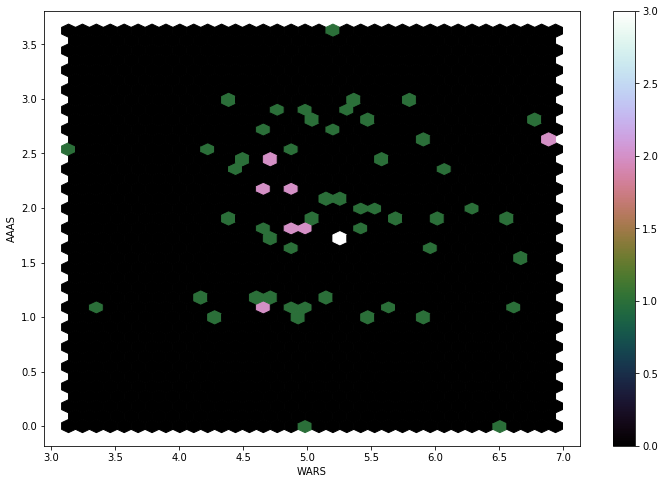

In [9]:
df.plot(y= 'AAAS', x ='WARS',kind='hexbin',gridsize=35, sharex=False, colormap='cubehelix',figsize=(12,8))

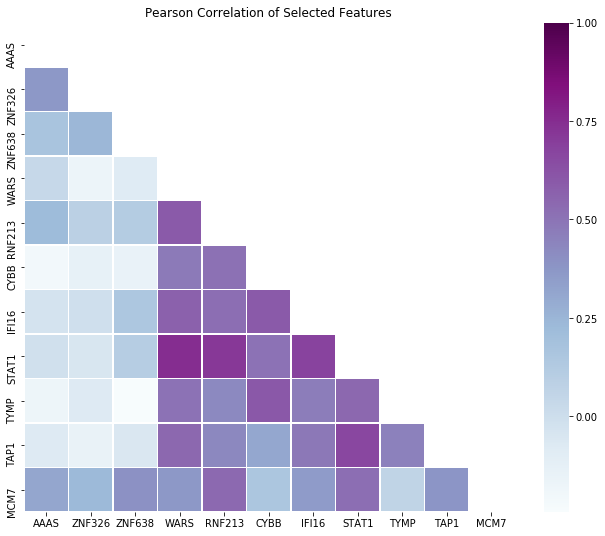

In [51]:
# Compute the correlation matrix 
# exclude 'Open' variable

lst = ['AAAS','ZNF326', 'ZNF638','WARS','RNF213','CYBB','IFI16','STAT1','TYMP','TAP1','MCM7'] # part of the list comes from Limma analysis


corr_all = df[(lst )].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))
plt.title('Pearson Correlation of Selected Features')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

PCA

In [11]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

Now having obtained the eigenvalues and eigenvectors, we will group them together by creating a list of eigenvalue, eigenvector tuples (immutable Python data objects). Following on from this we will sort the list in order of Highest eigenvalue to lowest eigenvalue and then use the eigenvalues to calculate both the individual explained variance and the cumulative explained variance for visualisation.

In [12]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

Now time to plot the explained variance graphs to see how our contributions look like. The cumulative explained variance is visualised in a blue step-plot while the individual explained variance is plotted via green bar charts as follows:

C:\Users\clfee\Anaconda3\lib\site-packages\matplotlib\transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
C:\Users\clfee\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


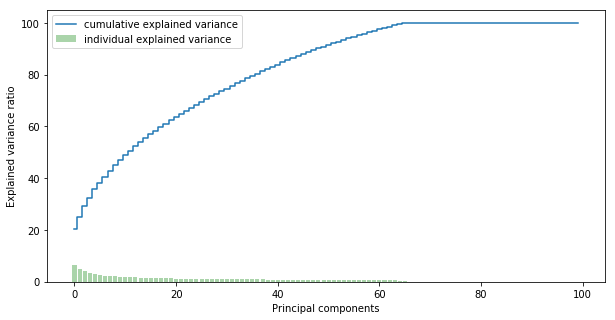

In [14]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(100), var_exp[1:101], alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(100), cum_var_exp[1:101], where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

Having roughly identified how many components/dimensions we would like to project on, let's now implement sklearn's PCA module.

The first line of the code contains the parameters "n_components" which states how many PCA components we want to project the dataset onto. Since we are going implement PCA with 40 components, therefore we set n_components = 40.

The second line of the code calls the "fit_transform" method, which fits the PCA model with the standardised movie data X_std and applies the dimensionality reduction on this dataset.

In [15]:
pca = PCA(n_components=40)
x_40d = pca.fit_transform(X_std)

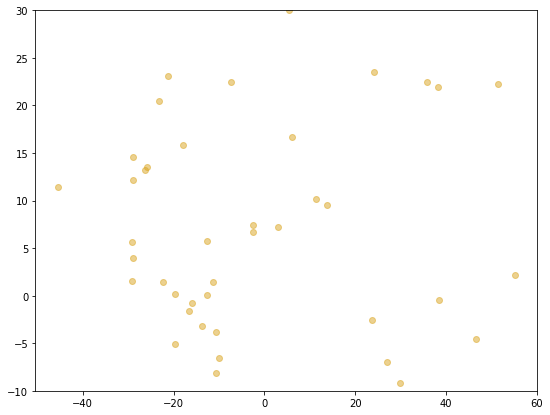

In [16]:
plt.figure(figsize = (9,7))
plt.scatter(x_40d[:,0],x_40d[:,1], c='goldenrod',alpha=0.5)
plt.ylim(-10,30)
plt.show()

KMeans clustering

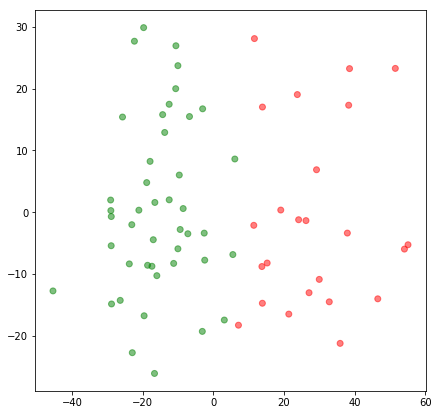

In [18]:
# Set a 3 KMeans clustering
kmeans = KMeans(n_clusters=2)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(x_40d)

# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(x_40d[:,0],x_40d[:,2], c= label_color, alpha=0.5) 
plt.show()

This KMeans plot looks more promising now as if our simple clustering model assumption turns out to be right, we can observe 2 distinguishable clusters via this color visualisation scheme.

In [21]:
# Create a temp dataframe from our PCA projection data "x_40d"
tp = pd.DataFrame(x_40d)
tp = tp[[0,1]] # only want to visualise relationships between first 2 projections
tp['X_cluster'] = X_clustered

C:\Users\clfee\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\clfee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\clfee\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


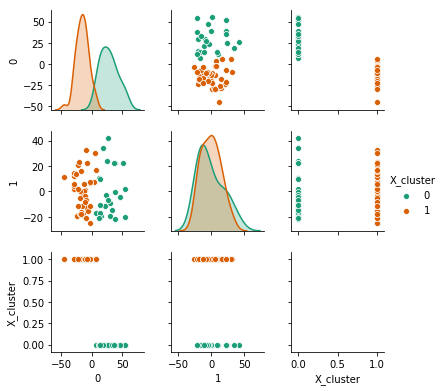

In [22]:
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(tp, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

#### Unsupervised Classification Results

In [37]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(df.msi, tp.X_cluster)

array([[ 5,  9],
       [19, 35]], dtype=int64)

###  Predict with PCA

In [41]:
# Split data

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

y = df.msi

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.2, 
                                                    stratify=y, 
                                                    random_state=42)

In [47]:
# Using PCA from sklearn PCA

pca = decomposition.PCA(n_components=40)

pca.fit(X_train)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.90476


In [49]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds.argmax(axis=1))

array([[ 2,  2],
       [ 0, 17]], dtype=int64)

<h3> Conclusion </h3>                                                                                                            

The task was performed without feature selection which can be done with Limma, Random Forest, or other methods.  
However, just by using PCA and KNN the classification accuracy has reached 0.9. 